# NCF Recommender with Explict Feedback

In this notebook we demostrate how to build neural network recommendation system with explict feedback. The system ([Recommendation systems: Principles, methods and evaluation](http://www.sciencedirect.com/science/article/pii/S1110866515000341)) normally prompts the user through the system interface to provide ratings for items in order to construct and improve his model. The accuracy of recommendation depends on the quantity of ratings provided by the user.  

Data: 
* The dataset we used is movielens-1M ([link](https://grouplens.org/datasets/movielens/1m/)), which contains 1 million ratings from 6000 users on 4000 movies.  There're 5 levels of rating. We will try classify each (user,movie) pair into 5 classes and evaluate the effect of algortithms using Mean Absolute Error.  
  
References: 
* A Keras implementation of Movie Recommendation([notebook](https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb)) from the [blog](http://blog.richardweiss.org/2016/09/25/movie-embeddings.html).
* Nerual Collaborative filtering ([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf))

## Intialization

* import necesary libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
import datetime as dt
from operator import itemgetter
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
%matplotlib inline

* import necessary modules from zoo

In [2]:
from zoo.models.recommendation import UserItemFeature
from zoo.models.recommendation import NeuralCF

* initilaize NN context

In [3]:
from zoo.common.nncontext import get_nncontext
sc = get_nncontext(create_spark_conf().setAppName("NCF Example"))

## Data Preparation

* Read movielens 1M data


In [4]:
from bigdl.dataset import movielens
movielens_data = movielens.get_id_ratings("/tmp/movielens/")	

* Understand the data.

Each record is in format of (userid, movieid, rating_score). UserIDs range between 1 and 6040. MovieIDs range between 1 and 3952. Ratings are made on a 5-star scale (whole-star ratings only). Counts of users and movies are recorded for later use.

In [5]:
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels= np.unique(movielens_data[:,2])

print movielens_data.shape
print min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels

(1000209, 3)
1 6040 1 3952 [1 2 3 4 5]


* Transform original data into RDD
BigDL requires train data and validation data to be provided in format of RDD([Sample](https://bigdl-project.github.io/master/#APIGuide/Data/#sample)). A `Sample` is a BigDL data structure which can be constructed using 2 numpy arrays, `feature` and `label` respectively. The API interface is `Sample.from_ndarray(feature, label)`

In [6]:
def build_sample(user_id, item_id, rating):
    sample = Sample.from_ndarray(np.array([user_id, item_id]), np.array([rating]))
    return UserItemFeature(user_id, item_id, sample)
pairFeatureRdds = sc.parallelize(movielens_data).map(lambda (uid, mid, rating): build_sample(uid, mid,rating))
pairFeatureRdds.take(3)

* Randomly split the data into train (80%) and validation (20%)

In [7]:
trainPairFeatureRdds, valPairFeatureRdds = pairFeatureRdds.randomSplit([0.8, 0.2], seed= 1L)
valPairFeatureRdds.cache()
train_rdd= trainPairFeatureRdds.map(lambda (pair_feature): pair_feature.sample)
val_rdd= valPairFeatureRdds.map(lambda (pair_feature): pair_feature.sample)

In [8]:
print train_rdd.count()
train_rdd.take(3)

799925


[Sample: features: [JTensor: storage: [   1.  661.], shape: [2], float], labels: [JTensor: storage: [ 3.], shape: [1], float],
 Sample: features: [JTensor: storage: [   1.  914.], shape: [2], float], labels: [JTensor: storage: [ 3.], shape: [1], float],
 Sample: features: [JTensor: storage: [  1.00000000e+00   3.40800000e+03], shape: [2], float], labels: [JTensor: storage: [ 4.], shape: [1], float]]

## Build Model

* Here we show an example of building a Neural collaborative filtering using ZooModel API. You can directly put the model into an Optimizer or NNClassifier. Please refer to the document for more details.

In [9]:
ncf = NeuralCF(max_user_id, max_movie_id, 5, hidden_layers=(20, 10), include_mf= False)

creating: createZooNeuralCF


## Setup the Optimizer

* Here, we show how to use an optimizer to train a model.
Optimizer tries to minimize the loss of the neural net with respect to its weights/biases, over the training set. To create an Optimizer in BigDL, you want to at least specify arguments: model(a neural network model), criterion(the loss function), traing_rdd(training dataset) and batch size. Please refer to ([ProgrammingGuide](https://bigdl-project.github.io/master/#ProgrammingGuide/optimization/))and ([Optimizer](https://bigdl-project.github.io/master/#APIGuide/Optimizers/Optimizer/)) for more details to create efficient optimizers.

In [10]:
optimizer = Optimizer(
    model=ncf,
    training_rdd=train_rdd,
    criterion=ClassNLLCriterion(),
    end_trigger=MaxEpoch(10),
    batch_size=2800,
    optim_method=Adam(learningrate=0.001))

optimizer.set_validation(
    batch_size=2800,
    val_rdd=val_rdd,
    trigger=EveryEpoch(),
    val_method=[MAE(), Loss(ClassNLLCriterion())]
)

creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createAdam
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createMAE
creating: createClassNLLCriterion
creating: createLoss


## Collect logs

* In BigDL, TrainSummary and ValidationSummary are logs which allow user to trace how indicators (e.g. learning rate, training loss, throughput, etc.) change with iterations/time in an optimization process.

A function of config_summaries is defined to collect monitoring data during training and validation phases.

In [11]:
def config_summaries(optimizer):
    """
    :param: optimizer: the optimizer created in start_train()
    """
    app_name = 'recommender-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")

    # train summary
    train_summary = TrainSummary(log_dir="./log", app_name=app_name)
    train_summary.set_summary_trigger("Loss", SeveralIteration(1))
    optimizer.set_train_summary(train_summary)

    # validation summary
    val_summary = ValidationSummary(log_dir="./log", app_name=app_name)
    optimizer.set_val_summary(val_summary)

    print "saving logs to ./log/" + app_name
    return train_summary, val_summary

train_summary, val_summary = config_summaries(optimizer)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to ./log/recommender-20180508-144330


## Train the model

In [12]:
optimizer.optimize()

## Prediction

* Zoo models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label. 

In [13]:
results = ncf.predict(val_rdd)
results.take(5)

results_class = ncf.predict_class(val_rdd)
results_class.take(5)

[5, 5, 4, 5, 4]

* In the Zoo, Recommender has provied 3 unique APIs to predict user-item pairs and make recommendations for users or items given candidates.
* Predict for user item pairs

In [14]:
userItemPairPrediction = ncf.predict_user_item_pair(valPairFeatureRdds)
print(userItemPairPrediction.take(3)[0])

UserItemPrediction [user_id: 1, item_id: 1193, prediction: 5, probability: 0.589590818068]


* Recommend 3 items for each user given candidates in the feature RDDs

In [15]:
userRecs = ncf.recommend_for_user(valPairFeatureRdds, 3)
print(userRecs.take(3)[0])

UserItemPrediction [user_id: 4904, item_id: 750, prediction: 5, probability: 0.830682377538]


* Recommend 3 users for each item given candidates in the feature RDDs

In [16]:
itemRecs = ncf.recommend_for_item(valPairFeatureRdds, 3)
itemRecs.take(3)[0]

## Evaluation

* plot the train and validation loss curves

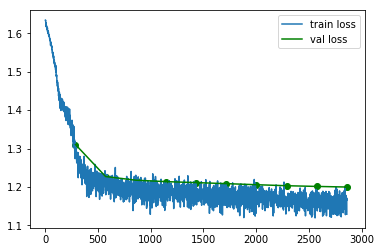

In [17]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
loss = np.array(train_summary.read_scalar("Loss"))
val_loss  = np.array(val_summary.read_scalar("Loss"))

#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.plot(loss[:,0],loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='val loss',color='green')
plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();

* plot the MAE curve during validation

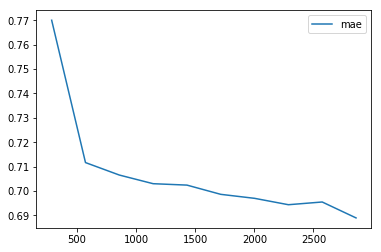

In [18]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
val_mae  = np.array(val_summary.read_scalar("MAE"))

#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.plot(val_mae[:,0],val_mae[:,1],label='mae')
plt.legend();

* output the final MAE on validation dataset

In [19]:
res2 = ncf.evaluate(val_rdd,2800,[MAE()])

creating: createMAE


In [20]:
'\n'.join([str(r) for r in res2])

'Evaluated result: 0.689235925674, total_num: 144, method: MAE'